In [ ]:
import numpy as np
import pandas as pd
import pandas.util.testing as tm

# visualization import
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df = pd.read_excel("project.xlsx")

In [ ]:
df.head()

,Date,Wave,Wind
0,2020-01-01,1526,7
1,2020-01-02,1478,5
2,2020-01-03,1441,6
3,2020-01-04,1431,6
4,2020-01-05,1469,9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    861 non-null    datetime64[ns]
 1   Wave    861 non-null    int64         
 2   Wind    861 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 20.3 KB


In [ ]:
df['Date'] = df['Date'].astype(np.int64)

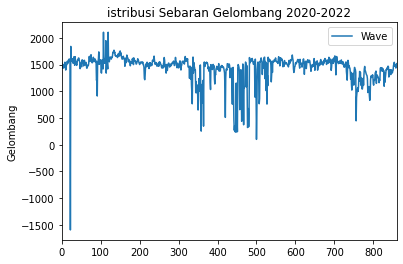

In [ ]:
title = 'istribusi Sebaran Gelombang 2020-2022'
ylabel = 'Gelombang'
xlabel='' #xlabel is not required. The datetime indes will be taken as the points on the x axis

ax = df['Wave'].plot(legend=True,title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel,ylabel=ylabel);

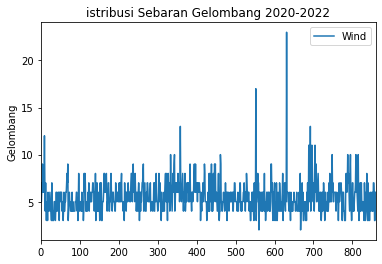

In [ ]:
title = 'istribusi Sebaran Gelombang 2020-2022'
ylabel = 'Gelombang'
xlabel='' #xlabel is not required. The datetime indes will be taken as the points on the x axis

ax = df['Wind'].plot(legend=True,title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel,ylabel=ylabel);

Stasionary check

In [ ]:
def dickey_fuller(series,title='Your Dataset'):
    '''Hypothesis Test for stationarity '''
    print(f'Augmented Dickey Fuller Test for the dataset {title}')
    
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [ ]:
dickey_fuller(df['Wave'],title='Wave')

Augmented Dickey Fuller Test for the dataset Wave
ADF test statistics      -4.244944
p-value                   0.000553
#lags                    11.000000
#observations           849.000000
critical value (1%)      -3.438076
critical value (5%)      -2.864950
critical value (10%)     -2.568586
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [ ]:
dickey_fuller(df['Wind'],title='Wind')

Augmented Dickey Fuller Test for the dataset Wind
ADF test statistics    -9.329216e+00
p-value                 9.427651e-16
#lags                   5.000000e+00
#observations           8.550000e+02
critical value (1%)    -3.438021e+00
critical value (5%)    -2.864926e+00
critical value (10%)   -2.568573e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Train & Test

In [ ]:
nobs = 12
train = df[:-nobs]
test = df[-nobs:]

In [ ]:
len(train), len(test)

(849, 12)

In [ ]:
p = [1,2,3,4,5,6,7]  # try with list of 7 p values

for i in p:
    model = VAR(train)
    results = model.fit(i)
    print(f'VAR Order {i}')
    print('AIC {}'.format(results.aic))
    print('BIC {}'.format(results.bic))
    print()

VAR Order 1
AIC 69.10216856121508
BIC 69.16928479662724

VAR Order 2
AIC 69.0873519635319
BIC 69.20491479067203

VAR Order 3
AIC 69.02312408697091
BIC 69.1912276103612

VAR Order 4
AIC 68.91009365966507
BIC 69.12883227323539

VAR Order 5
AIC 68.81081773562204
BIC 69.08028612394028

VAR Order 6
AIC 68.74068215876605
BIC 69.06097529827507

VAR Order 7
AIC 68.69167213154236
BIC 69.06288529180364



In [ ]:
# lets confirm that both the variables are included in the model
model.endog_names

['Date', 'Wave', 'Wind']

In [ ]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 27, May, 2022
Time:                     00:59:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    69.0803
Nobs:                     844.000    HQIC:                   68.9141
Log likelihood:          -32582.9    FPE:                7.65886e+29
AIC:                      68.8108    Det(Omega_mle):     7.23930e+29
--------------------------------------------------------------------
Results for equation Date
             coefficient             std. error           t-stat            prob
--------------------------------------------------------------------------------
const           0.000000  14897103862984.787109            0.000           1.000
L1.Date         0.727861               0.047657           15.273           0.000
L1.Wave         0.000000       305790404.050241            0.

In [ ]:
lag_order = results.k_ar
lag_order

5

In [ ]:
z = results.forecast(y=train.values[-lag_order:],steps = 12)
z

array([[1.65119110e+18, 1.33921726e+03, 5.55609269e+00],
       [1.65127801e+18, 1.34784036e+03, 5.55638141e+00],
       [1.65136511e+18, 1.35794806e+03, 5.54759893e+00],
       [1.65145239e+18, 1.36977710e+03, 5.58323941e+00],
       [1.65153982e+18, 1.38027649e+03, 5.57434227e+00],
       [1.65162726e+18, 1.38650122e+03, 5.58036008e+00],
       [1.65171486e+18, 1.39479557e+03, 5.58820754e+00],
       [1.65180254e+18, 1.40175047e+03, 5.59553285e+00],
       [1.65189028e+18, 1.40735629e+03, 5.59459283e+00],
       [1.65197808e+18, 1.41248189e+03, 5.60140887e+00],
       [1.65206597e+18, 1.41763333e+03, 5.60492437e+00],
       [1.65215389e+18, 1.42171807e+03, 5.60741626e+00]])

In [ ]:
test

,Date,Wave,Wind
849,1651190400000000000,1344,5
850,1651276800000000000,1381,4
851,1651363200000000000,1398,4
852,1651449600000000000,1483,6
853,1651536000000000000,1514,4
854,1651622400000000000,1543,7
855,1651708800000000000,1472,7
856,1651795200000000000,1501,6
857,1651881600000000000,1483,3
858,1651968000000000000,1436,3


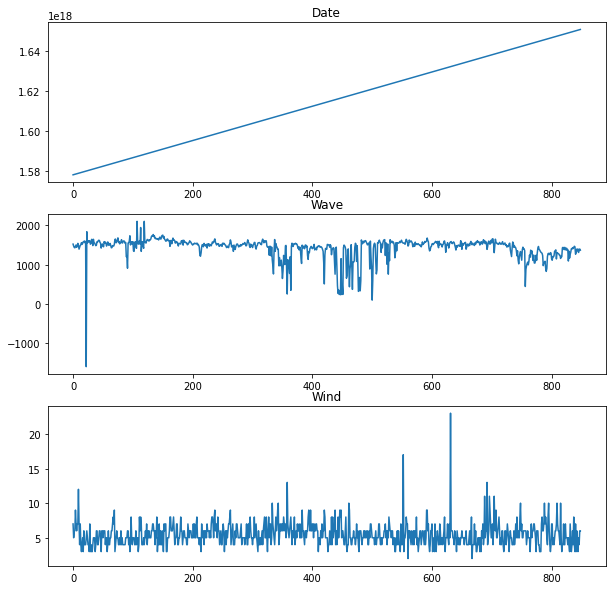

In [ ]:
results.plot();

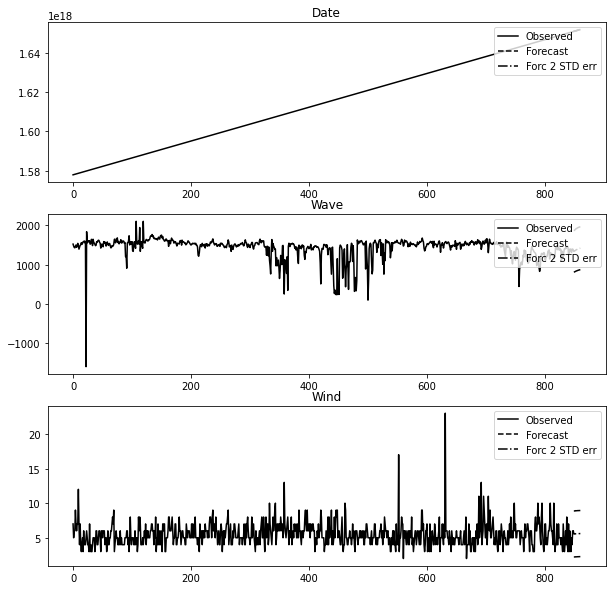

In [ ]:
results.plot_forecast(12);